In [1]:
import numpy as np 
from PIL import Image, ImageDraw, ImageFont 
from skimage import transform as tf

In [3]:
def create_captcha(text, shear=0, size=(100, 30), scale=1):
    im = Image.new("L", size, "black")
    draw = ImageDraw.Draw(im)
    font = ImageFont.truetype("arial", 22) 
    draw.text((0, 0), text, fill=1, font=font)
    image = np.array(im)
    affine_tf = tf.AffineTransform(shear=shear)
    image = tf.warp(image, affine_tf)
    image = image / image.max()
    shape = image.shape
    # Apply scale
    shapex, shapey = (shape[0] * scale, shape[1] * scale)
    image = tf.resize(image, (shapex, shapey))
    return image

C:\Users\sonaw\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


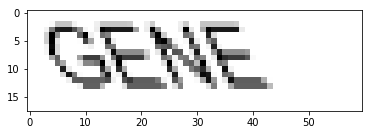

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
image = create_captcha("GENE", shear=0.5, scale=0.6)
plt.imshow(image, cmap='Greys')

In [5]:
from skimage.measure import label, regionprops

In [6]:
from skimage.measure import label, regionprops
from skimage.filters import threshold_otsu
from skimage.morphology import closing, square

In [7]:
def segment_image(image):
    # label will find subimages of connected non-black pixels
    labeled_image = label(image>0.2, connectivity=1, background=0)
    subimages = []
    # regionprops splits up the subimages
    for region in regionprops(labeled_image):
        # Extract the subimage
        start_x, start_y, end_x, end_y = region.bbox
        subimages.append(image[start_x:end_x,start_y:end_y])
    if len(subimages) == 0:
        # No subimages found, so return the entire image
        return [image,]
    return subimages

In [8]:
subimages = segment_image(image)

In [9]:
len(subimages)

4

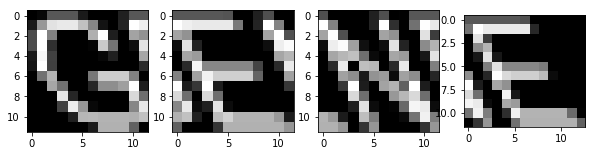

In [10]:
f, axes = plt.subplots(1, len(subimages), figsize=(10, 3)) 
for i in range(len(subimages)): 
    axes[i].imshow(subimages[i], cmap="gray")

In [11]:
from sklearn.utils import check_random_state
random_state = check_random_state(14) 
letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
assert len(letters) == 26
shear_values = np.arange(0, 0.8, 0.05)
scale_values = np.arange(0.9, 1.1, 0.1)

In [12]:
def generate_sample(random_state=None): 
    random_state = check_random_state(random_state) 
    letter = random_state.choice(letters) 
    shear = random_state.choice(shear_values)
    scale = random_state.choice(scale_values)
    return create_captcha(letter, shear=shear, size=(30, 30), scale=scale), letters.index(letter)

The target for this image is: L


C:\Users\sonaw\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


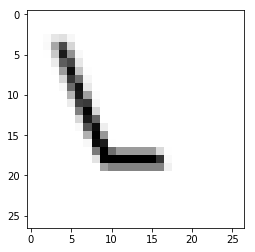

In [13]:
image, target = generate_sample(random_state) 
plt.imshow(image, cmap="Greys") 
print("The target for this image is: {0}".format(letters[target]))

In [14]:
dataset, targets = zip(*(generate_sample(random_state) for i in range(1000)))
dataset = np.array([tf.resize(segment_image(sample)[0], (20, 20)) for sample in dataset])
dataset = np.array(dataset, dtype='float') 
targets = np.array(targets)

C:\Users\sonaw\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [15]:
from sklearn.preprocessing import OneHotEncoder 
onehot = OneHotEncoder() 
y = onehot.fit_transform(targets.reshape(targets.shape[0],1))

In [16]:
y = y.todense()

In [17]:
X = dataset.reshape((dataset.shape[0], dataset.shape[1] * dataset.shape[2]))

In [18]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

C:\Users\sonaw\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [19]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(100,), random_state=14)
clf.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_iter': 200,
 'momentum': 0.9,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 14,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [20]:
clf.fit(X_train, y_train)

C:\Users\sonaw\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=14, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [21]:
len(clf.coefs_)

2

In [22]:
clf.coefs_[0].shape


(400, 100)

In [23]:
clf.coefs_[1].shape


(100, 26)

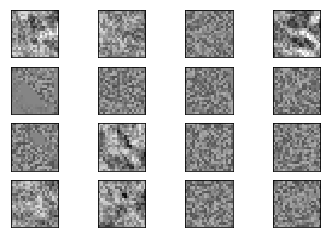

In [24]:
fig, axes = plt.subplots(4, 4)
# use global min / max to ensure all weights are shown on the same scale
vmin, vmax = clf.coefs_[0].min(), clf.coefs_[0].max()
for coef, ax in zip(clf.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(20, 20), cmap=plt.cm.gray, vmin=.5 * vmin,
               vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()

In [25]:
y_pred = clf.predict(X_test)

from sklearn.metrics import f1_score


f1_score(y_pred=y_pred, y_true=y_test, average='macro')

1.0

In [26]:
from sklearn.metrics import classification_report


In [27]:
print(classification_report(y_pred=y_pred, y_true=y_test))


             precision    recall  f1-score   support

          0       1.00      1.00      1.00         4
          1       1.00      1.00      1.00         4
          2       1.00      1.00      1.00         6
          3       1.00      1.00      1.00         4
          4       1.00      1.00      1.00         6
          5       1.00      1.00      1.00        10
          6       1.00      1.00      1.00         3
          7       1.00      1.00      1.00         3
          8       1.00      1.00      1.00         4
          9       1.00      1.00      1.00         2
         10       1.00      1.00      1.00         4
         11       1.00      1.00      1.00         3
         12       1.00      1.00      1.00         3
         13       1.00      1.00      1.00         4
         14       1.00      1.00      1.00         6
         15       1.00      1.00      1.00         3
         16       1.00      1.00      1.00         3
         17       1.00      1.00      1.00   

In [28]:
def predict_captcha(captcha_image, neural_network):
    subimages = segment_image(captcha_image)
    dataset = np.array([tf.resize(subimage, (20, 20)) for subimage in subimages])
    X_test = dataset.reshape((dataset.shape[0], dataset.shape[1] * dataset.shape[2]))

    y_pred = neural_network.predict_proba(X_test)
    predictions = np.argmax(y_pred, axis=1)
    assert len(y_pred) == len(X_test)
    predicted_word = str.join("", [letters[prediction] for prediction in predictions])
    return predicted_word

In [29]:
clf.predict_proba

<bound method MLPClassifier.predict_proba of MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=14, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)>

In [30]:
word = "GENE"
captcha = create_captcha(word, shear=0.2) 
print(predict_captcha(captcha, clf))

GENE


C:\Users\sonaw\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


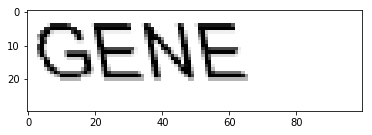

In [31]:
plt.imshow(captcha, cmap="Greys")

C:\Users\sonaw\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


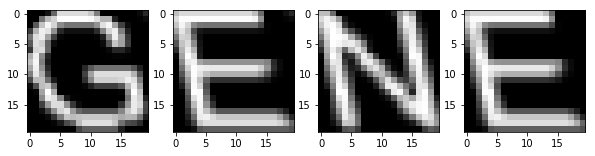

In [32]:
subimages = segment_image(captcha)
f, axes = plt.subplots(1, len(subimages), figsize=(10, 3)) 
for i in range(len(subimages)): 
    axes[i].imshow(tf.resize(subimages[i], (20,20)), cmap="gray")

C:\Users\sonaw\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


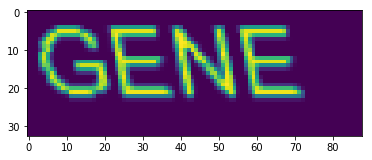

In [33]:
image = create_captcha(word, shear=0.2, scale=1.1, size=(len(word) * 20, 30))
plt.imshow(image)

In [37]:
def test_prediction(word, net, shear=0.2, scale=1):
    captcha = create_captcha(word, shear=shear, scale=scale, size=(len(word) * 20, 30))
    prediction = predict_captcha(captcha, net)
    return word == prediction, word, prediction

In [38]:
from nltk.corpus import words

In [39]:
valid_words = [word.upper() for word in words.words() if len(word) == 4]

In [40]:
if False:
    correct = 0
    incorrect = 0

    for word in valid_words:
        shear = random_state.choice(shear_values)
        scale = random_state.choice(scale_values)
        subimages = create_captcha(word, shear=shear, scale=scale, size=(30, len(word) * 25))

In [41]:
num_correct = 0 
num_incorrect = 0 
for word in valid_words: 
    shear = random_state.choice(shear_values)
    scale = random_state.choice(scale_values)
    correct, word, prediction = test_prediction(word, clf, shear=shear, scale=scale)
    #print(correct, word, prediction)
    if correct: 
        num_correct += 1 
    else: 
        num_incorrect += 1
        #if len(prediction) == len(word):
        #    print(word, prediction)
print("Number correct is {0}".format(num_correct)) 
print("Number incorrect is {0}".format(num_incorrect))

C:\Users\sonaw\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Number correct is 3819
Number incorrect is 1694


In [42]:
def evaluation_versus_shear(shear_value):
    print(shear_value)
    num_correct = 0 
    num_incorrect = 0 
    for word in valid_words: 
        scale = random_state.choice(scale_values)
        correct, word, prediction = test_prediction(word, clf, shear=shear_value, scale=scale)
        #print(correct, word, prediction)
        if correct: 
            num_correct += 1 
        else: 
            num_incorrect += 1
    return num_correct/(num_correct+num_incorrect)

In [43]:
scores = [evaluation_versus_shear(shear) for shear in shear_values]

0.0


C:\Users\sonaw\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


0.05
0.1
0.15000000000000002
0.2
0.25
0.30000000000000004
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.65
0.7000000000000001
0.75


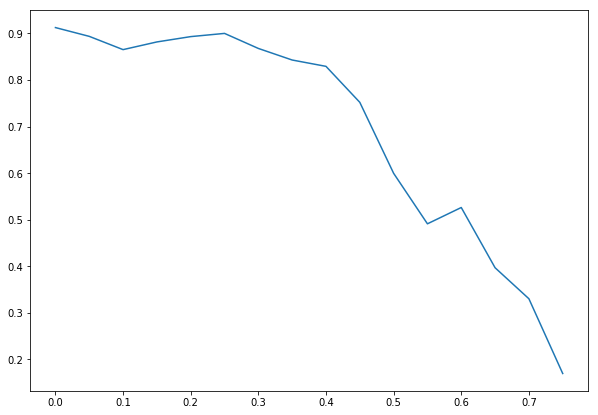

In [44]:
import seaborn
plt.figure(figsize=(10, 7))
plt.ylabel = "Accuracy"
plt.xlabel = "Shear"
plt.plot(shear_values, scores)

In [45]:
from nltk.metrics import edit_distance 
steps = edit_distance("STEP", "STOP") 
print("The number of steps needed is: {0}".format(steps))

The number of steps needed is: 1


In [46]:
def compute_distance(prediction, word):
    
    len_word = min(len(prediction), len(word))
    
    return len_word - sum([prediction[i] == word[i] for i in range(len_word)])

In [47]:
from operator import itemgetter 

def improved_prediction(word, net, dictionary, shear=0.2, scale=1.0): 
    captcha = create_captcha(word, shear=shear, scale=scale) 
    prediction = predict_captcha(captcha, net) 
    
    if prediction not in dictionary:
        distances = sorted([(word, compute_distance(prediction, word)) for word in dictionary], key=itemgetter(1))
        best_word = distances[0] 
        prediction = best_word[0]
    return word == prediction, word, prediction

In [48]:
num_correct = 0 
num_incorrect = 0 
for word in valid_words: 
    shear = random_state.choice(shear_values)
    scale = random_state.choice(scale_values)
    correct, word, prediction = improved_prediction(word, clf, valid_words, shear=shear, scale=scale)
    #print(correct, word, prediction)
    if correct: 
        num_correct += 1 
    else: 
        num_incorrect += 1
        #if len(prediction) == len(word):
        #    print(word, prediction)
print("Number correct is {0}".format(num_correct)) 
print("Number incorrect is {0}".format(num_incorrect))

C:\Users\sonaw\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Number correct is 4215
Number incorrect is 1298


In [47]:
p = num_correct/(num_correct+num_incorrect)
p

0.5158715762742608